# __[QCforQC project](https://research-software-directory.org/projects/qcforqc)__

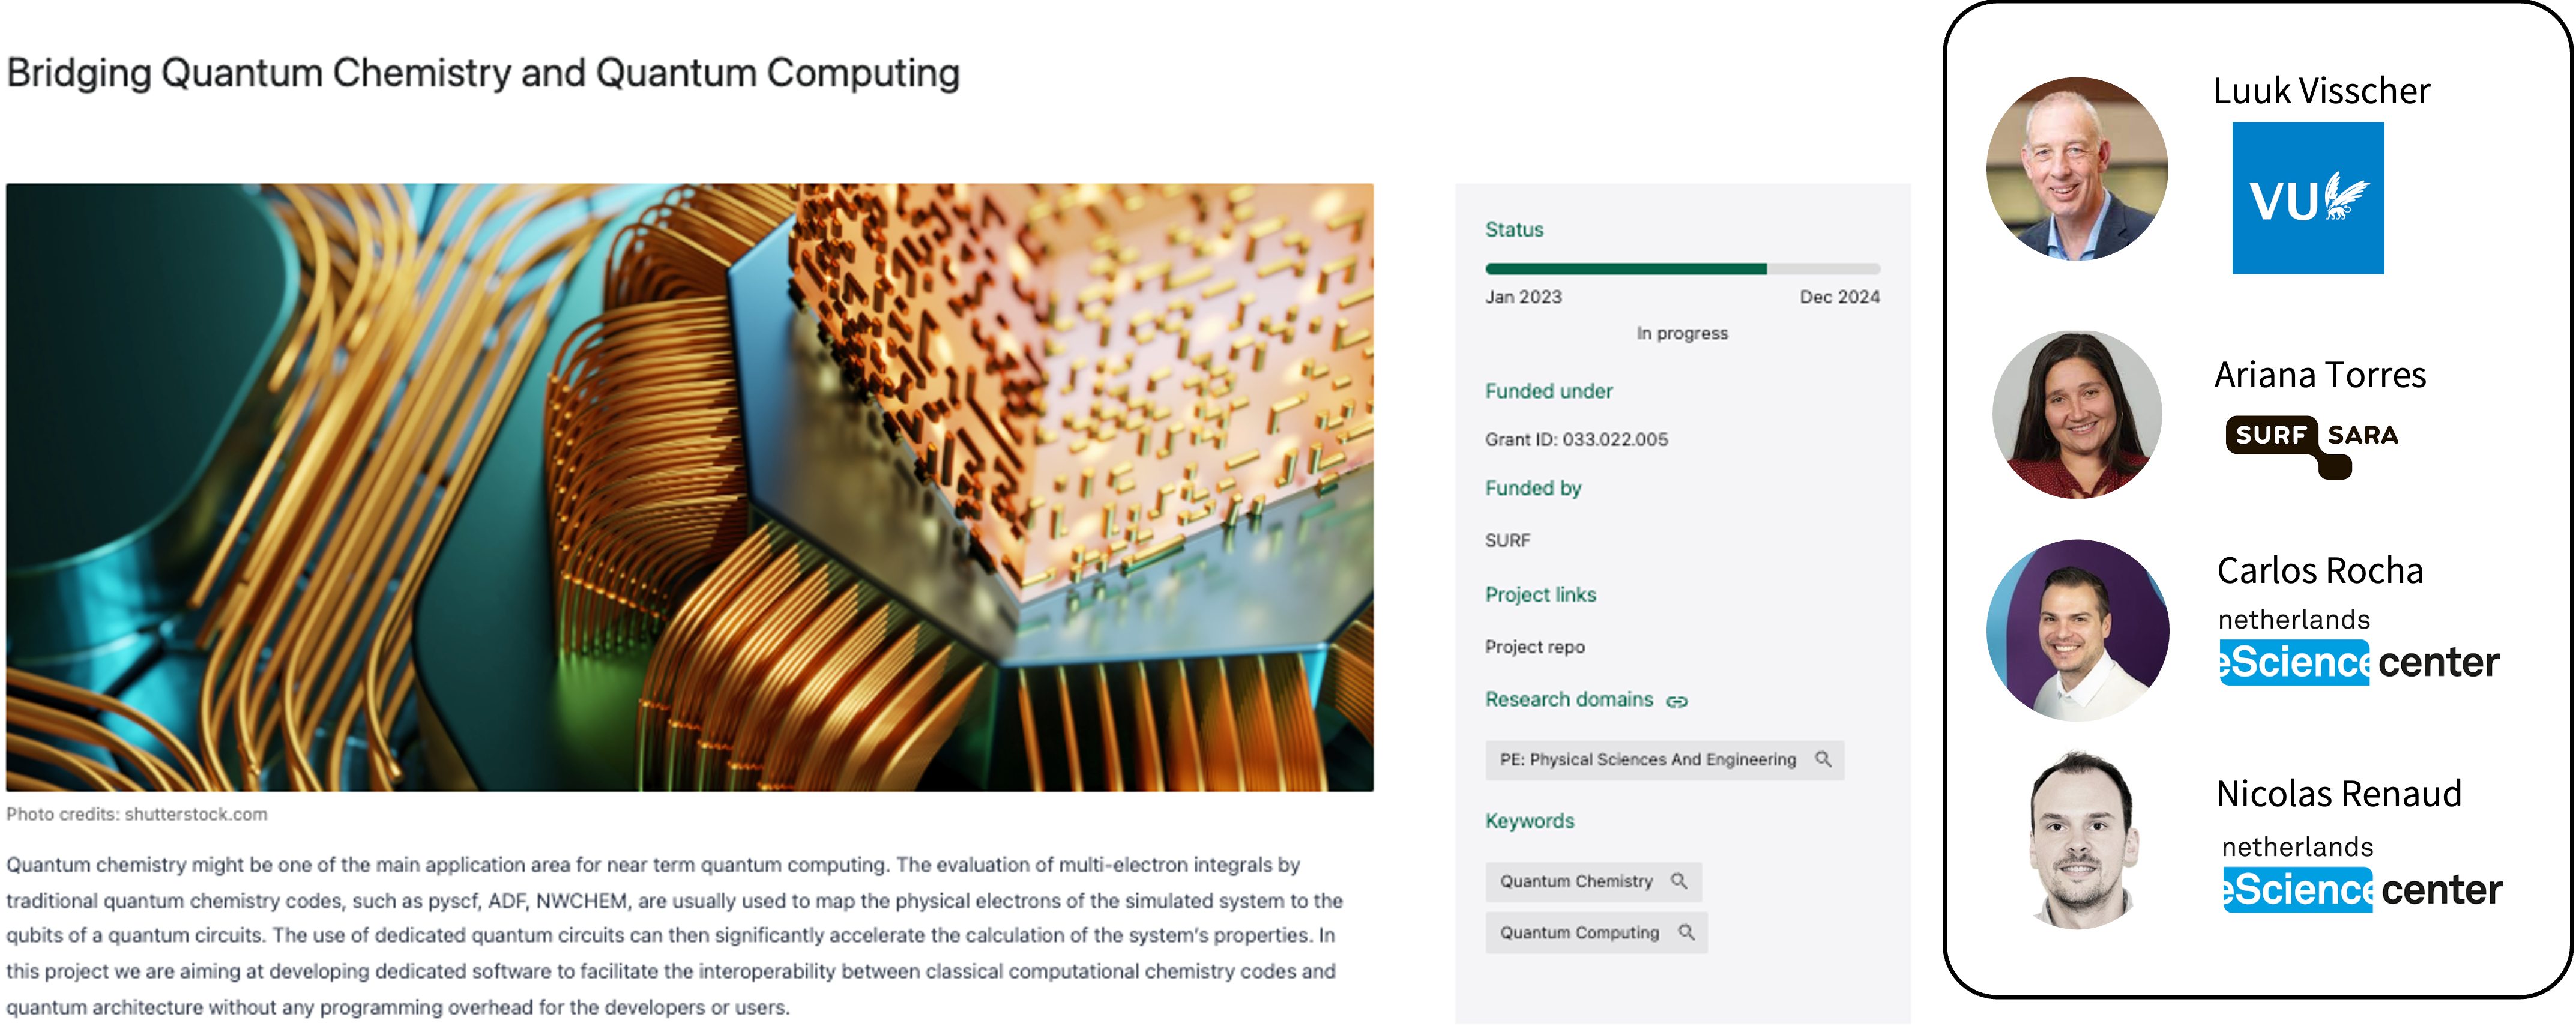

# __[qc2 software](https://github.com/qc2nl/qc2)__

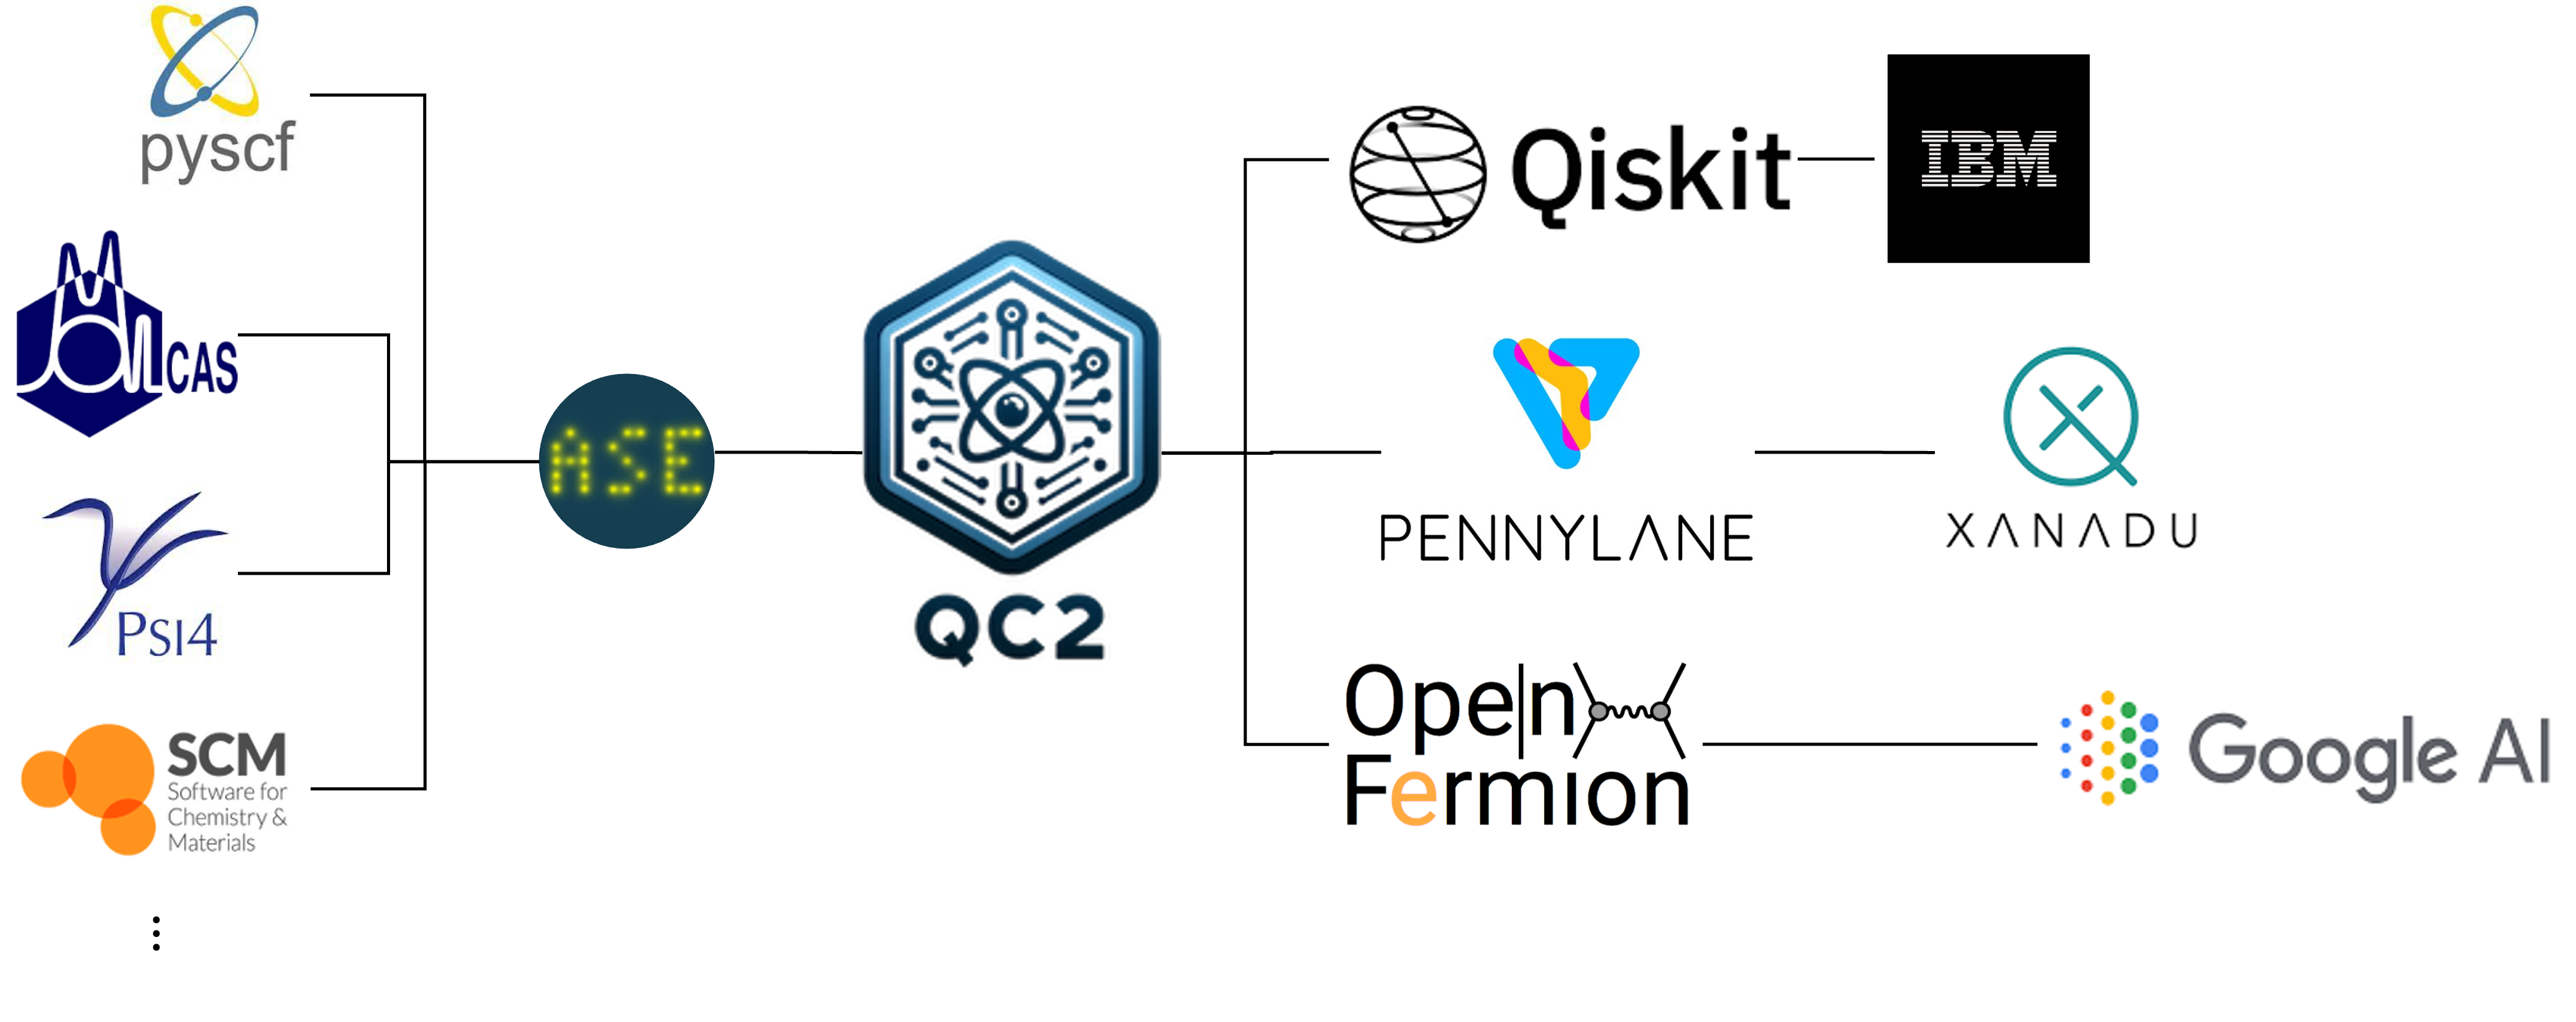

qc2 is an open-source python package specifically crafted for hybrid quantum-classical algorithms such as VQE and oo-VQE (see later). It embraces several *core design principles*:

- **Leveraging Existing Tools**: qc2 is interoperable with existing open-source quantum chemistry tools, like Atomic Simulation Environment (ASE) calculators, and adheres to standard data schemas, such as QCSchema or FCIDump. This ensures efficient data exchange necessary for various quantum computing libraries.
  
- **Seamless Integration with Quantum Computing SDKs**: qc2 is designed to work effortlessly with Qiskit and PennyLane, ensuring a smooth user experience for developers.

- **Modularity**: The package boasts high modularity, featuring a robust built-in algorithms package that simplifies extensions and enhancements.

- **User-Friendly Design**: qc2 is straightforward and has an intuitive interface, enabling users to focus on their research and applications with minimal technical details.

For more details on qc2 and full installation instructions, see: __[https://github.com/qc2nl/qc2](https://github.com/qc2nl/qc2)__ and __[https://qc2.readthedocs.io/](https://qc2.readthedocs.io/)__.

A recent blog about qc2: __[https://medium.com/@carlosmurilorocha/69ee18ef2969](https://medium.com/@carlosmurilorocha/69ee18ef2969)__.


### Installation

```bash
git clone https://github.com/qc2nl/qc2.git
cd qc2
pip install -e .[dev,pennylane]  # use ".[dev,pennylane]" if you have zsh shell
pip install pylatexenc           # for circuit 'mpl' draw option  
```

# Preliminary considerations

- Assumes the audience has little to no understanding of quantum computing.

- Draw parallels with traditional quantum chemistry wherever possible.

- Does not focus on applications but uses simple examples to provide a comprehensive overview of quantum chemistry calculations on quantum computers.

- Uses only algorithms for finding the ground-state energy of a few target systems.
  
- Uses only simulators (exact or noisy) rather than real quantum hardware.

# Example #1: Variational Quantum Eigensolver (VQE) calculation on H$_{2}$

In this example, we demonstrate the basics of the Variational Quantum Eigensolver (VQE) step-by-step, using the H$_{2}$ molecule as an example. We utilize `qc2` in conjunction with `Qiskit` and its implemented `Estimator` primitive to calculate exact expectation values using `StateVector`.

### Learning objectives

- Provide a basic understanding of the steps needed to perform quantum computations on molecules, focusing on the VQE algorithm.

The figure below shows a general schematic representation of a VQE workflow:

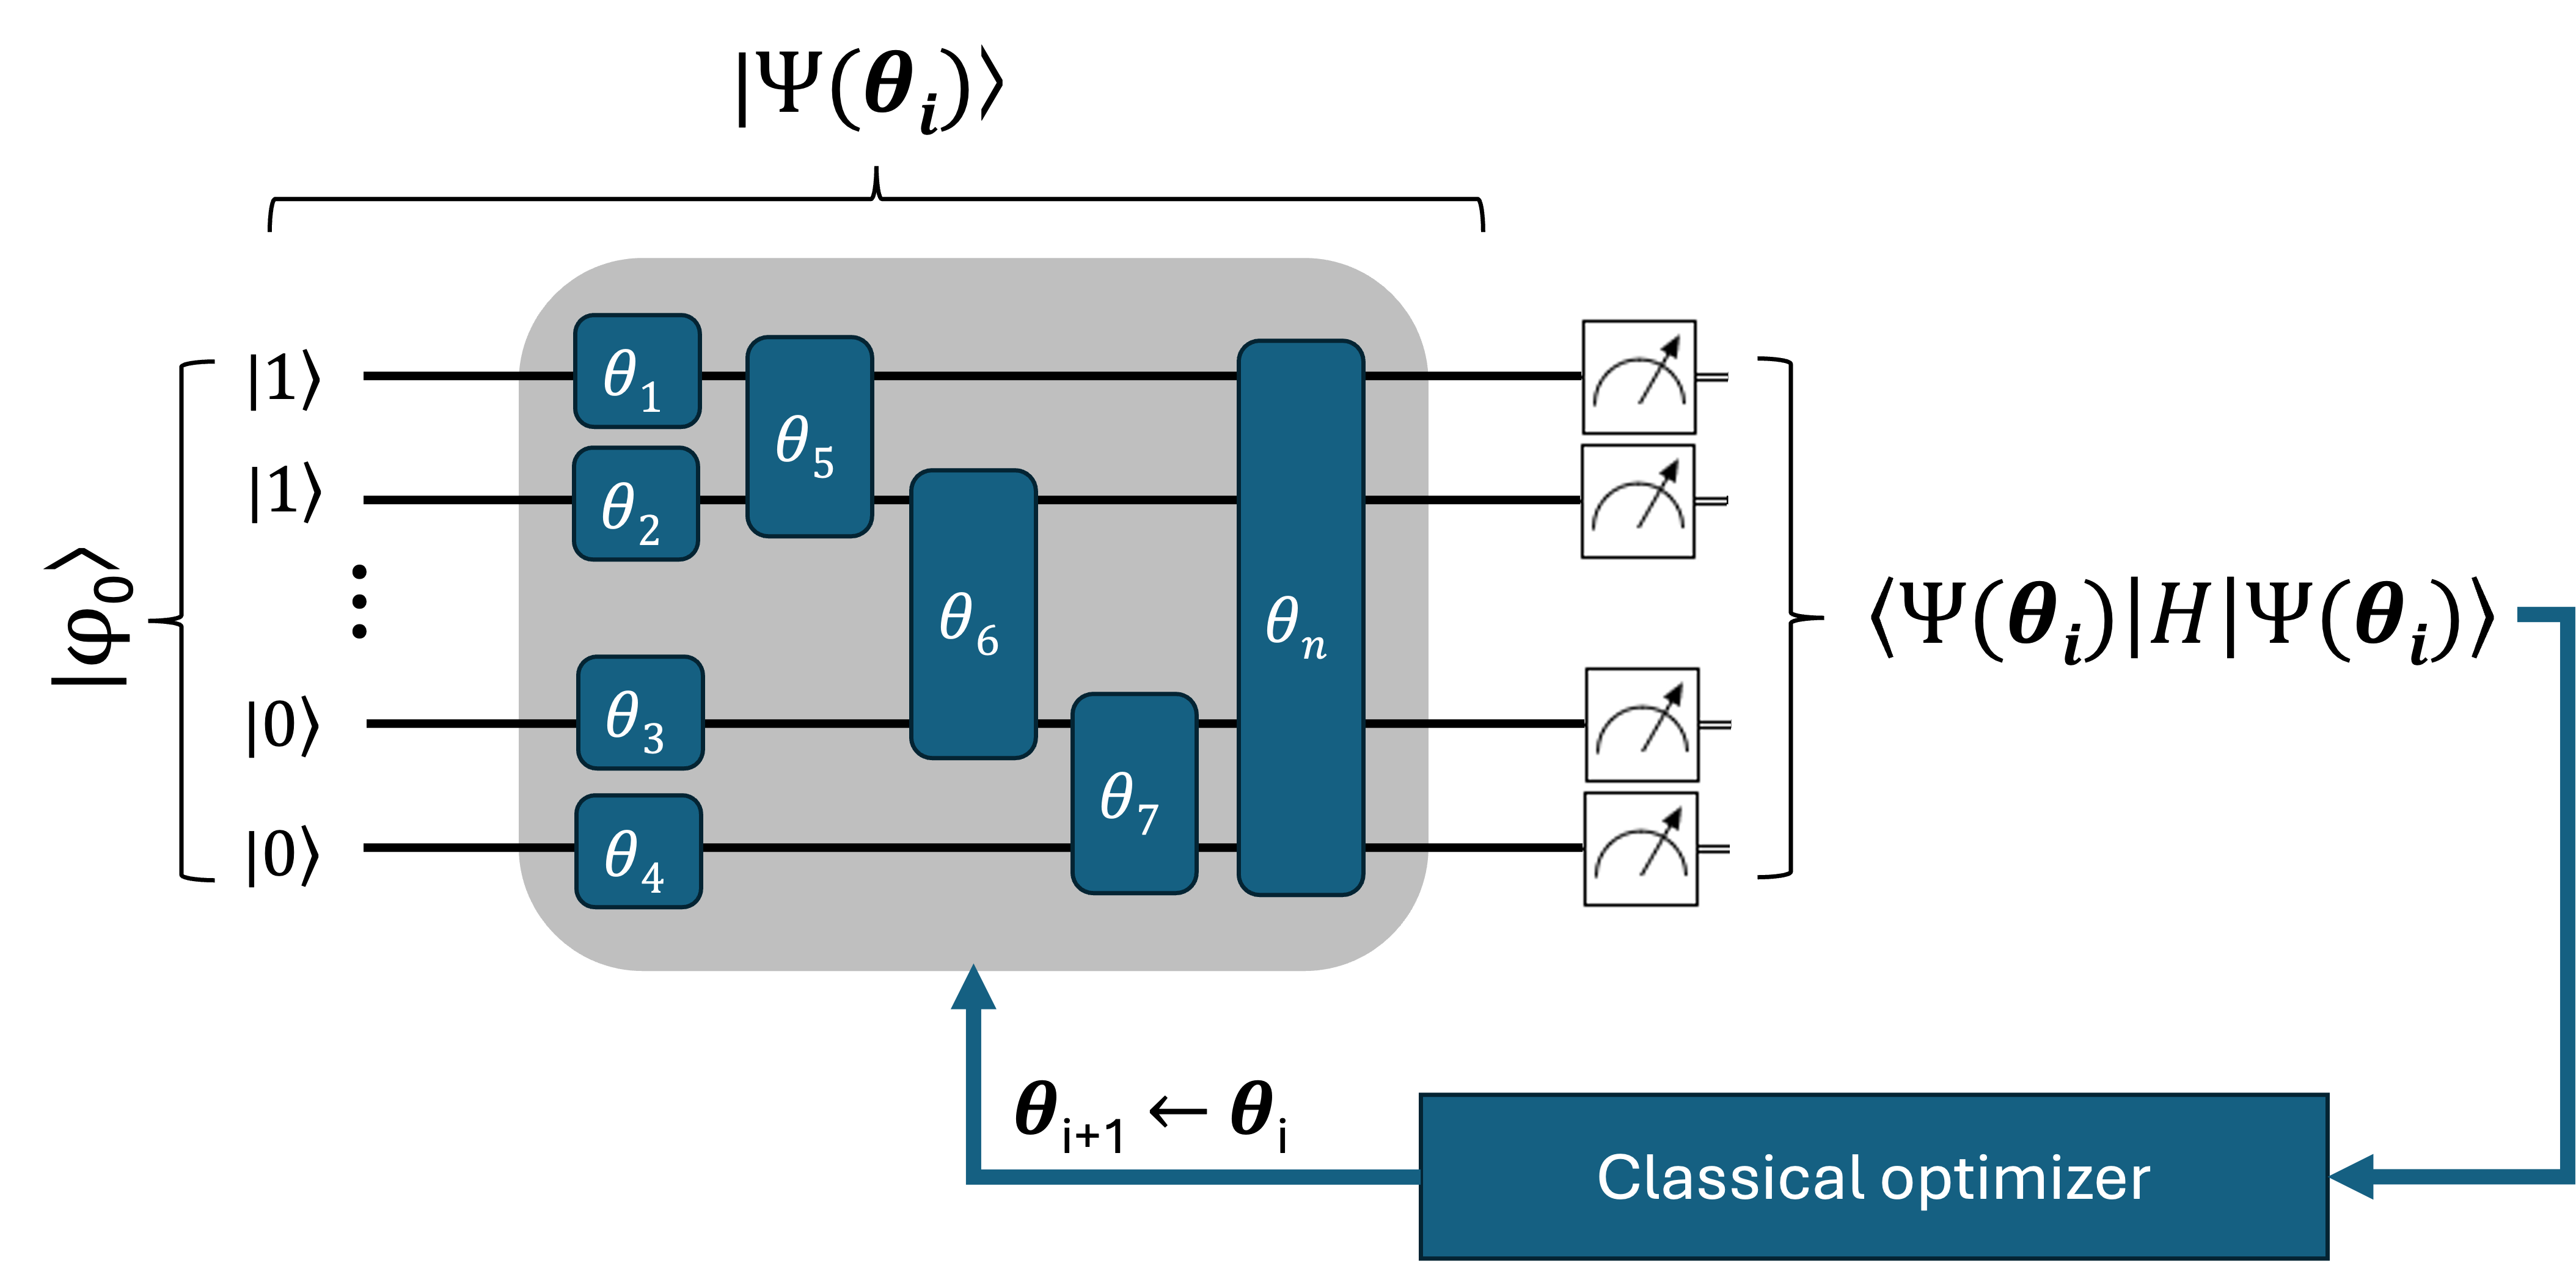

In general, the VQE algorithm requires the following input information:

- **Reference State**: A reference quantum circuit and initial qubit states. This is accomplished done by directly mapping the Hartree-Fock spin-orbitals' occupation numbers into initial qubit states.

- **Ansatz**: Type of variational form used. This corresponds to the type and sequence of parametrized quantum gates we utilize to transform the initial qubit states. The ansatz contains parameters, $\boldsymbol{\theta}$, that can be optimized in a variational fashion.

- **Qubit molecular Hamiltonian**: This process involves mapping the molecular Hamiltonian in second quantization (constructed from classical quantum chemistry data) into a sum of Pauli quantum gates.

- **Classical optimizer**: The classical optimization routine to optimize the circuit variational parameters.

### Step #1. Import required packages

As a first step, we import all required libraries; those related to `qc2` but also additional packages we use in the calculation like `Qiskit` and `Qiskit-Nature`, as well as the ASE `molecule` builder.

In [1]:
# ASE molecule object
from ase.build import molecule

# qiskit-related packages
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import optimizers as opt
from qiskit.primitives import Estimator
from qiskit.circuit.library import RealAmplitudes

# qc2 packages
from qc2.data import qc2Data
from qc2.ase import PySCF

### Step #2. Set target molecule and run reference wave function calculation

As in traditional quantum chemistry (correlated calculation), we need to first define the molecular geometry of our target system and set up a reference wave function. 

In `qc2` this is done by instantiating its core class, `qc2Data`, which is the main communication point between qchem codes and quantum computing packages. 
The initial Hartree-Fock calculation is done by qc2-ASE customized calculators.

In [2]:
# set Atoms object
mol = molecule('H2')

# instantiate qc2Data class
qc2data = qc2Data(
    molecule=mol,
    filename='h2.hdf5',
)

# specify the qchem qc2-ASE calculator
qc2data.molecule.calc = PySCF(method='scf.RHF', basis='sto-3g')

# run calculation and save qchem data into a hdf5 file
qc2data.run()

* Reference energy (Hartree): -1.11690055771897
* Saving qchem data in h2.hdf5



This run will generate a formatted `h2.hdf5` file containing all relevant quantum chemistry data to be used/recycled later on, *e.g.*, molecular geometry, reference energy, molecular orbitals, electron integrals. 

To check the its data structure, run the following command in your shell:

In [3]:
!h5dump -n h2.hdf5

HDF5 "h2.hdf5" {
FILE_CONTENTS {
 group      /
 group      /keywords
 group      /model
 group      /molecule
 group      /properties
 group      /provenance
 group      /wavefunction
 dataset    /wavefunction/localized_orbitals_a
 dataset    /wavefunction/localized_orbitals_b
 dataset    /wavefunction/scf_eigenvalues_a
 dataset    /wavefunction/scf_eigenvalues_b
 dataset    /wavefunction/scf_eri
 dataset    /wavefunction/scf_eri_mo_aa
 dataset    /wavefunction/scf_eri_mo_ab
 dataset    /wavefunction/scf_eri_mo_ba
 dataset    /wavefunction/scf_eri_mo_bb
 dataset    /wavefunction/scf_fock_a
 dataset    /wavefunction/scf_fock_mo_a
 dataset    /wavefunction/scf_fock_mo_b
 dataset    /wavefunction/scf_orbitals_a
 dataset    /wavefunction/scf_orbitals_b
 }
}


### Step #3. Set up reference circuit and ansatz

As discussed earlier, we are now in position to build up our reference quantum circuit. `Qiskit` has a `HartreeFock` built-in class that can easily be used for this purpose.

* Reference circuit:


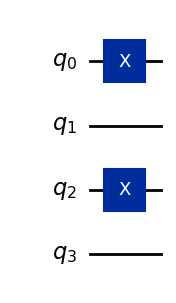

In [4]:
# build up the reference quantum circuit
quantum_circuit = HartreeFock(
    num_spatial_orbitals=2,
    num_particles=(1, 1),
    qubit_mapper=JordanWignerMapper(),
)

print(f'* Reference circuit:')
display(quantum_circuit.draw('mpl'))

In the example above, each $q_{i}$ represents a qubit whose state directly correlates with the corresponding $\alpha$ and $\beta$ spin-orbitals' population numbers. In this example, the HF determinant is expressed as the $| 1 0 1 0 \rangle$ qubit state. Remember that the Pauli `X` gate has the effect of flipping the initial qubit's $| 0 \rangle$ to the $| 1 \rangle$ state. What is left now is to define an appropriate **ansatz** or **parametrized quantum circuit**:

* Ansatz (RealAmplitudes):


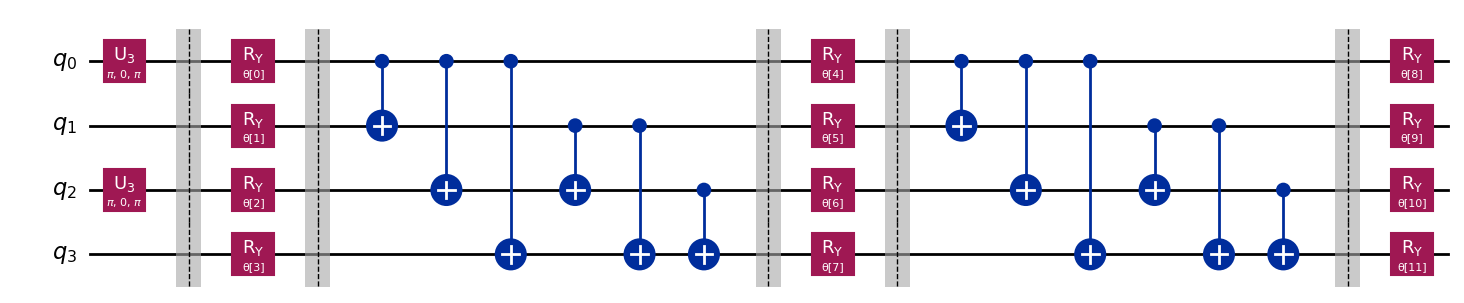

In [5]:
# Create ansatz
n_qubits = quantum_circuit.num_qubits
ansatz = RealAmplitudes(n_qubits, entanglement='full', reps=2, insert_barriers=True)
quantum_circuit.barrier()
quantum_circuit.compose(ansatz, inplace=True)

print(f'* Ansatz (RealAmplitudes):')
quantum_circuit.decompose().draw('mpl')

As you can see, the final **parametrized quantum circuit** is composed of series of quantum gates that transform somehow the initial/reference states of the qubits. Note that some gates, *e.g.*, the $R_{y}(\theta[n])$ rotation gate, depend on certain qubit rotation parameters, $\theta[n]$. These angles can be fine tuned at will so that the final circuit reproduces a desired observable or quantum property. The other gates shown in blue, the so-called `CNOT`, do not depend on parameters but are very important as they are responsible for capturing two qubit interactions.

Although the use of problem-inspired ansatze like *Unitary Coupled Cluster* is customary in Quantum Chemistry (see later), in this example we employ for demonstration/didatic purposes a *RealAmplitudes* ansatz.

### Step #4. Building up the molecular qubit Hamiltonian

Once a proper quantum circuit has been set, the next step is to build up a proper qubit representation of our molecular Hamiltonian whose expectation value will measured at the end of each circuit evaluation.

This is done in a two step process.

First, we need to build molecular Hamiltonian in fermionic (specifically, in second-quantized) representation:

\begin{equation}
\hat{H} = \sum_{pq} h_{pq} a_{p}^\dagger a_{q} + \frac{1}{2} \sum_{pqrs} h_{pqrs} a_{p}^\dagger a_{q}^\dagger a_{r} a_{s}
\end{equation}

where $a_{i}^\dagger$ and $a_{i}$ are raising and lowering operators that removes/creates an electron from/in an orbital with label $p$. Here the coefficients $h_{pq}$ and $h_{pqrs}$ are given by the molecular integrals which can be efficiently computed classically for many choices of one-electron basis functions:

\begin{equation}
h_{pq} = \int dx \, \phi^{*}_{p}(x)\left( \frac{\nabla^{2}_{r}}{2} - \sum_{i} \frac{Z_{i}}{|\boldsymbol{R}_{i} - \boldsymbol{r}|}\right) \phi_{q}(x), \qquad h_{pqrs} = \int dx_{1} dx_{2} \, \frac{\phi^{*}_{p}(x_{1})\phi^{*}_{q}(x_{2})\phi_{s}(x_{1})\phi_{r}(x_{2})}{|\boldsymbol{r}_{1} - \boldsymbol{r}_{2}|}
\end{equation}

To extract the expectation value of the problem Hamiltonian, the second step involves expressing it as a linear combination of primitive tensor products of Pauli matrices $\hat{\sigma_{x}}$, $\hat{\sigma_{y}}$, and $\hat{\sigma_{z}}$. We refer to these tensor products as *Pauli
strings* $\hat{P} = \bigotimes_{j=1}^{n}\hat{\boldsymbol{\sigma}}$ where $n$ is the number of qubits, $\hat{\boldsymbol{\sigma}} \in \left\{ \hat{\sigma_{x}}, \hat{\sigma_{y}}, \hat{\sigma_{z}}, \hat{I} \right\}$ and $\hat{I}$ the identity operator. Then, the
Hamiltonian can be decomposed as:

\begin{equation}
\hat{H} = \sum_{k=1}^{M} c_{k} \hat{P}_{k}
\end{equation}

where $c_{k}$ is a complex coefficient of the $k$-th Pauli string and the number of Pauli strings $M$ in the expansion depends on the operator at hand.
There are several method that has been proposed for this and in this tutorial we use the so-called Jordan−Wigner Mapping as implemented in the `JordanWignerMapper` class of `Qiskit-Nature`.


In [6]:
# set up qubit Hamiltonian and core energy
nuc_rep_energy, qubit_ham = qc2data.get_qubit_hamiltonian(
    num_electrons=(1, 1),
    num_spatial_orbitals=2,
    mapper=JordanWignerMapper(),
    format='qiskit'
)

# molecular Hamiltonian as a linear combination of Pauli strings.
qubit_ham.to_list()

[('IIII', (-0.8112557075915287+0j)),
 ('IIIZ', (0.17184931866629147+0j)),
 ('IIZI', (-0.224744498489859+0j)),
 ('IZII', (0.17184931866629125+0j)),
 ('ZIII', (-0.2247444984898589+0j)),
 ('IIZZ', (0.12078809196857412+0j)),
 ('IZIZ', (0.1688241922338747+0j)),
 ('ZIIZ', (0.16605110981082177+0j)),
 ('YYYY', (0.0452630178422477+0j)),
 ('XXYY', (0.0452630178422477+0j)),
 ('YYXX', (0.0452630178422477+0j)),
 ('XXXX', (0.0452630178422477+0j)),
 ('IZZI', (0.16605110981082188+0j)),
 ('ZIZI', (0.1745434714459975+0j)),
 ('ZZII', (0.12078809196857412+0j))]

### Step #5. Run VQE algorithm

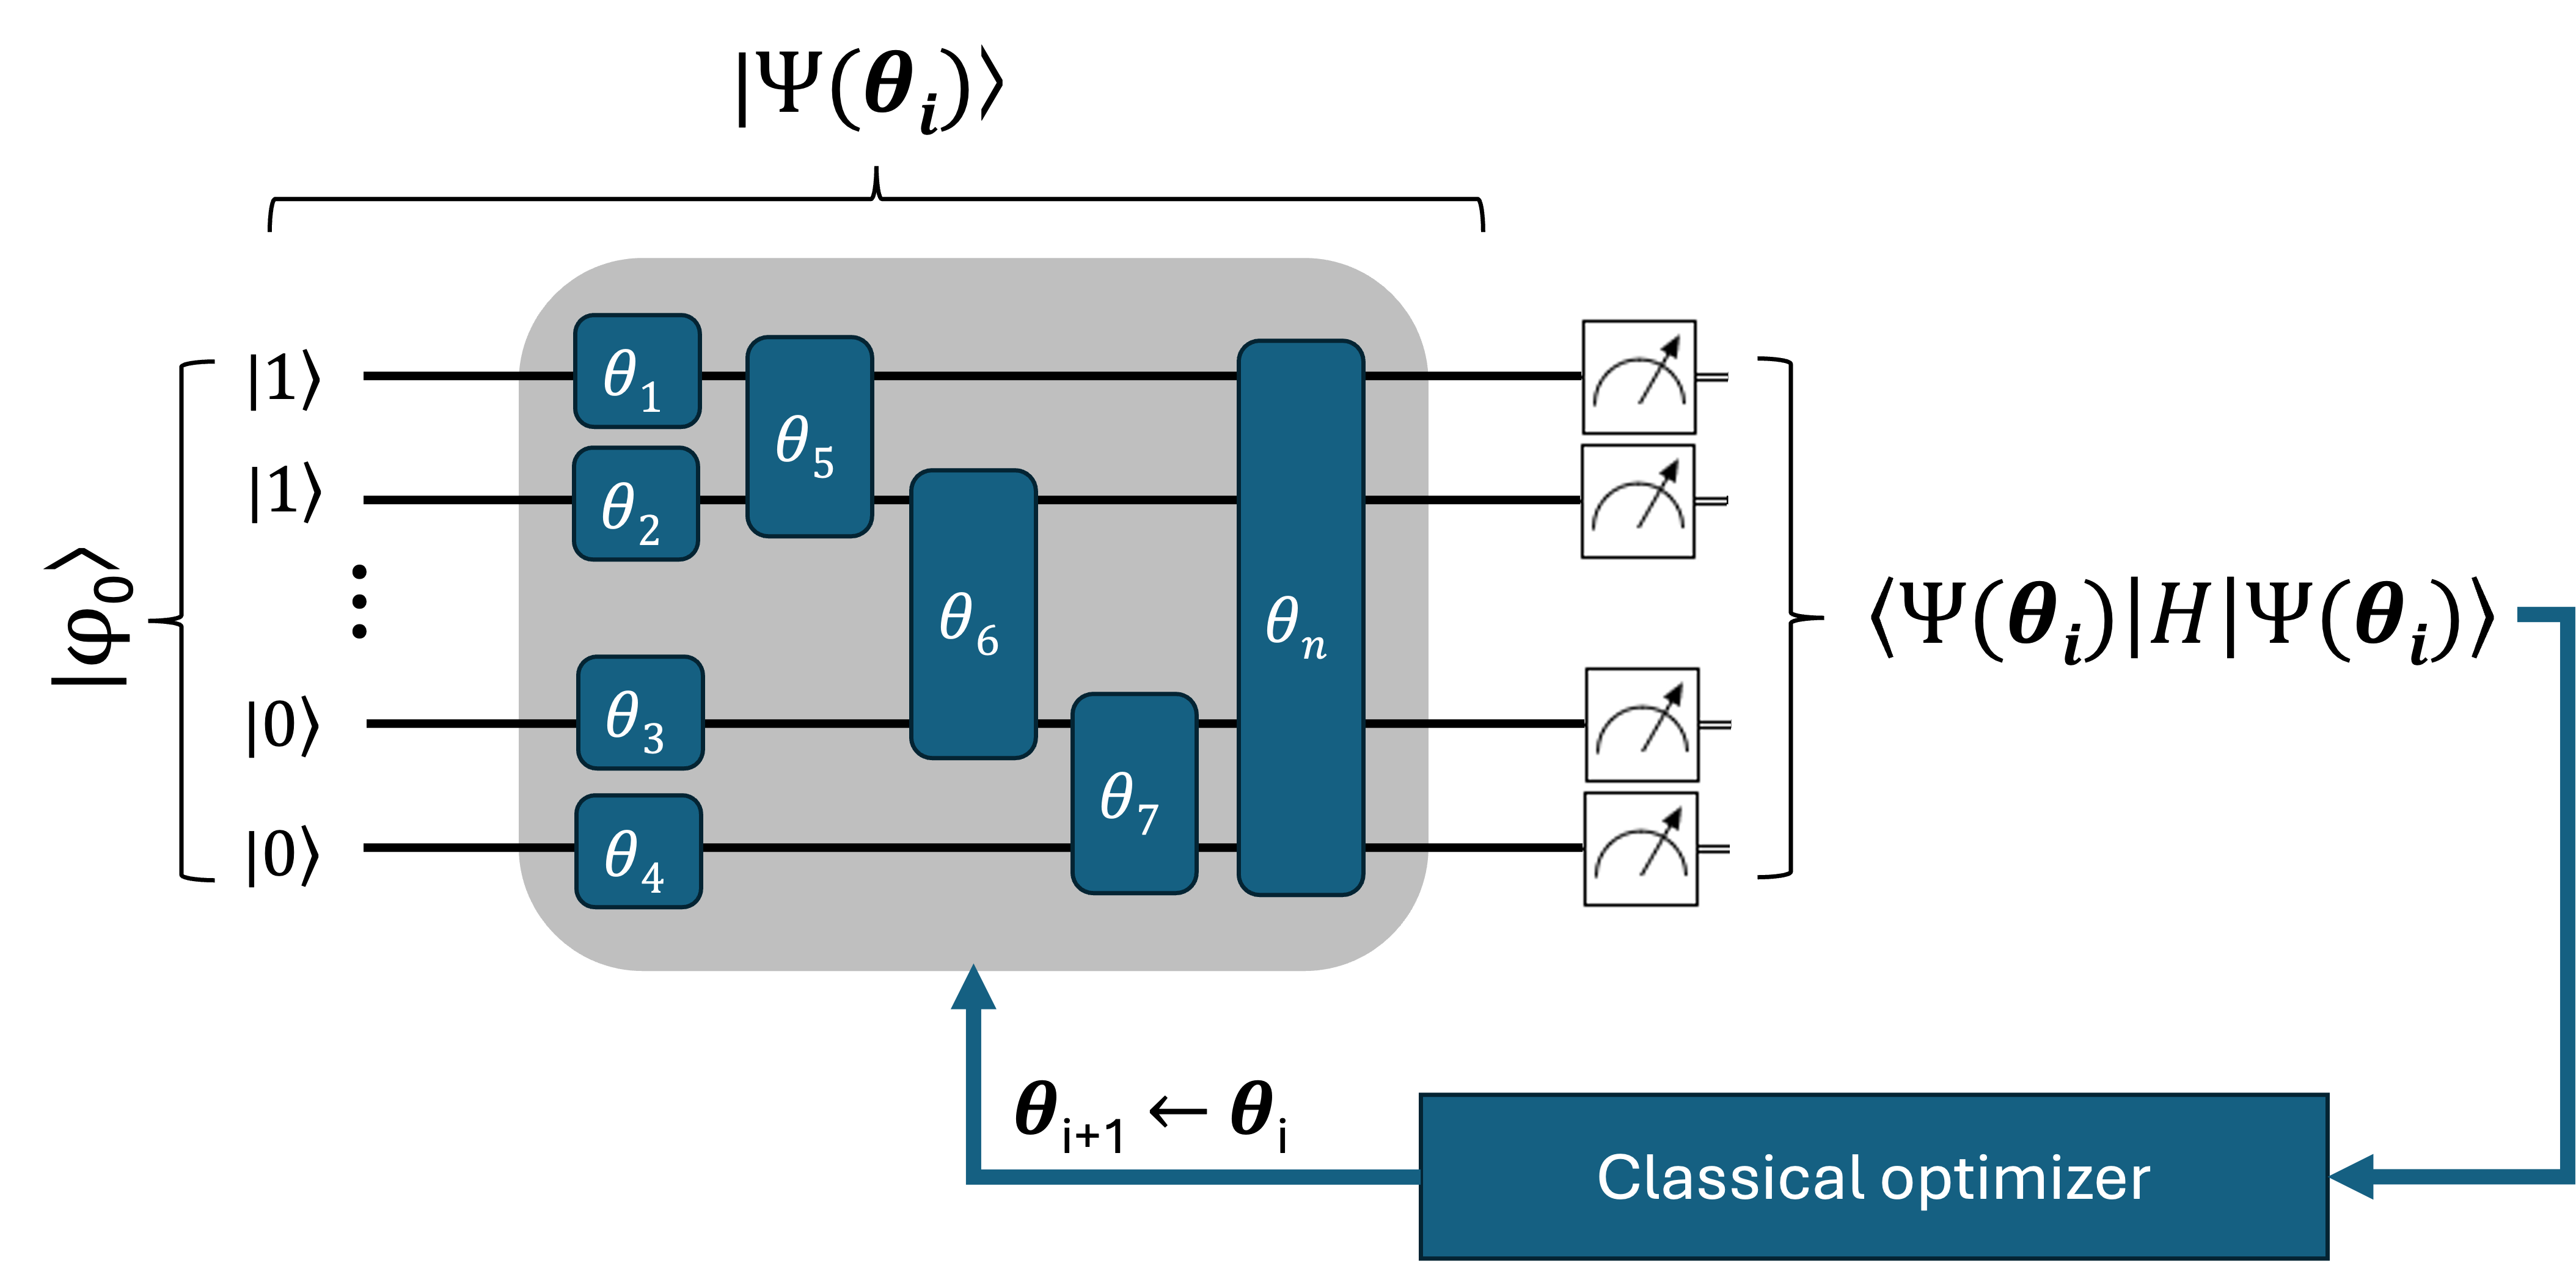

Finally, we are now in position to run our quantum algorithm. To facilitate this process, I will create a function that evaluates the circuit and measures the Hamiltonian expectation value for a givens set of circuit parameters $\boldsymbol{\theta}$.

Remember that, in the context of Quantum Chemistry and Variational Principle, the expectation value is the quantity that we want to minimize, *i.e*, our problem's cost function.

In [7]:
def cost_function(theta) -> float:
    """Runs the circuit and calculates the expectation value of the Hamiltonian for given circuit parameters."""
    job = Estimator().run(
        circuits=quantum_circuit,
        observables=qubit_ham,
        parameter_values=theta
    )
    cost = job.result().values + nuc_rep_energy
    # print(f">>> Total ground state energy (Hartree): {cost}")
    return cost

The only task left is now to choose a external classical optimization routine and initial guesses for our circuit parameters. The best parameters are the ones that produce the lowest possible expectation value. The final energy corresponds to the ground-state energy of the target molecule as predicted by VQE.

In [8]:
initial_theta = [0.0] * quantum_circuit.num_parameters

optimizer = opt.COBYLA()  # => gradient-free optimizer

result = optimizer.minimize(
    cost_function,
    x0=initial_theta
)

print("=== QISKIT VQE RESULTS ===\n")
print(f">>> Total ground state energy (hartree): {result.fun}\n")
print(f">>> Best circuit parameters:\n\n {result.x}")

=== QISKIT VQE RESULTS ===

>>> Total ground state energy (hartree): -1.1357678890513543

>>> Best circuit parameters:

 [ 2.37973345e-01  9.41931439e-04  1.65300409e+00 -1.56459226e-01
  1.38978548e+00 -1.52254881e+00  4.85899115e-01 -2.67264953e-01
  1.39690936e+00  1.33316265e+00 -1.57114334e+00  1.79610580e-01]


# Example #2: Potential energy curve of H$_{2}$

In this example, we show how to use `qc2` alongside with `Qiskit` for calculating the potential energy curve (PEC) of the hydrogen molecule.
We perform quantum simulations to calculate exact expectation values using `StateVector`. Additionally, we show the effects of a simple noise model on the final results using `Qiskit`'s `AerSimulator`.


### Learning objectives

- Demonstrate that quantum calculations can be performed as simple as traditional quantum chemistry.

- Provide a basic understanding of the types of quantum backends and the effects of quantum noise.

### Note on quantum backends

A "quantum backend" refers to the component responsible for executing quantum circuits; simulators or real quantum hardware.

- **Exact Simulators**: Simulations that compute the exact quantum state vector of a quantum circuit. An example is `Statevector` in `Qiskit`.
These simulations are very useful for quickly prototyping algorithms before looking into more advanced simulation techniques or running on real devices.
Ideal for small to medium-sized circuits where you need to analyze the precise quantum state, as it provides exact results.

- **Noisy Simulators**: Currently existing quantum processors suffer from errors, or noise, so the results of an exact simulation do not necessarily reflect the results you would expect when running circuits on real hardware. These are more versatile simulators that truly simulate the noisy environment of real quantum devices. An example is the `AerSimulator` from `Qiskit Aer` package.

- **Real quantum hardware**: Refers to actual quantum processors available through IBM Quantum or other quantum computing services. They are used only for production runs are generally require some *post-hoc* processing using **error mitigation techniques**.

### Step #1. Import packages

In [9]:
import numpy as np

# ASE molecule object
from ase import Atoms

# qiskit-related packages
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import optimizers as opt

# qc2 packages
from qc2.data import qc2Data
from qc2.ase import PySCF

### Step #2. Set up calculation details

To start with, let's set up some simple variables that we will useful later. 

In [10]:
# set up equilibrium geometry and initial circuit parameters in rads
req = 0.737166
req_params = [1.57079357, 1.57087253, 1.45852109]

# define vector of internuclear distances to loop over
r_distances = [r*req for r in np.arange(0.5, 5, 0.5)]

### Step #3a. Loop over internuclear distances: `StateVector` simulator

To obtain the PEC, we need to perform a loop over selected internuclear geometries and calculate the corresponding ground-state electronic energy.

In [11]:
# define file to write the calculated data to
quantum_output_file = 'h2_pec_quantum_simulator.data'
file = open(quantum_output_file, "w", encoding='utf-8')

# set up quantum backend and estimator
backend = AerSimulator()
estimator = Estimator(options=dict(
    run_options=dict(shots=4000, seed=42)
))

for r in r_distances:

    # set Atoms object
    mol = Atoms(
        'H2',
        positions=[[0.,  0.,  0.],
                   [0.,  0.,  r]]
    )
    
    # instantiate qc2Data class
    qc2data = qc2Data(molecule=mol, filename='h2_pec.hdf5')

    # specify and run qc2-ASE calculator
    qc2data.molecule.calc = PySCF(method="scf.RHF", basis="sto-3g")
    qc2data.run()
    
    # build up the reference quantum circuit and ansatz
    reference_circuit = HartreeFock(num_spatial_orbitals=2, num_particles=(1, 1), qubit_mapper=JordanWignerMapper())
    ansatz = UCCSD(num_spatial_orbitals=2, num_particles=(1, 1), qubit_mapper=JordanWignerMapper(), initial_state=reference_circuit)
    
    # transpile the circuit
    pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit =  pass_manager.run(ansatz)
    # isa_observable = qubit_ham.apply_layout(isa_circuit.layout)

    # set up qubit Hamiltonian and nuclear repulsion energy
    nuc_rep_energy, qubit_ham = qc2data.get_qubit_hamiltonian(num_electrons=(1, 1), num_spatial_orbitals=2, mapper=JordanWignerMapper(), format='qiskit')


    # define cost function
    def cost_function(theta) -> float:
        """Runs the circuit and calculates the expectation value of the Hamiltonian for given circuit parameters."""
        # evaluate expectation value using the estimator and chosen backend
        job = estimator.run([(isa_circuit, qubit_ham, theta)])
        cost_result = job.result()
        return (cost_result[0].data.evs + nuc_rep_energy)


    # for each geometry, optimize circuit parameters using a classical optimization routine
    result = opt.COBYLA().minimize(cost_function, x0=req_params)
    
    print(f">>> Total VQE ground state energy (Hartree): {result.fun}\n")

    # write relevant data to file
    data_to_write = f"{r} {result.fun}\n"
    file.write(data_to_write)
    
file.close()

* Reference energy (Hartree): -0.8323959925858826
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -0.8415563433226201

* Reference energy (Hartree): -1.11690055771897
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -1.137301540395935

* Reference energy (Hartree): -1.0347677703871998
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -1.0778998165295541

* Reference energy (Hartree): -0.9186044326889027
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -1.0023474279638422

* Reference energy (Hartree): -0.8185133354304797
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -0.9583666605138561

* Reference energy (Hartree): -0.7444704693706192
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -0.9409204379613512

* Reference energy (Hartree): -0.6935395490285441
* Saving qchem data in h2_pec.hdf5

>>> T

### Step #3b. Loop over internuclear distances: Noisy simulator

Here, we do the same as before but now using a noise model.

In [12]:
# define file to write the calculated data to
noisy_quantum_output_file = 'h2_pec_quantum_noisy_simulator.data'
file = open(noisy_quantum_output_file, "w", encoding='utf-8')

# build up a noise model by importing the noise scheme of a real backend
# noise_model = NoiseModel.from_backend(FakeManilaV2())

noise_model = NoiseModel()
cx_depolarizing_prob = 0.001  # => add later a 0.1% on every two-qubit CNOT gate
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

# set up quantum backend and estimator
backend = AerSimulator()
estimator = Estimator(options=dict(
    backend_options=dict(noise_model=noise_model),
    run_options=dict(shots=4000, seed=42)
))

for r in r_distances:

    # set Atoms object
    mol = Atoms(
        'H2',
        positions=[[0.,  0.,  0.],
                   [0.,  0.,  r]]
    )
    
    # instantiate qc2Data class
    qc2data = qc2Data(molecule=mol, filename='h2_pec.hdf5')

    # specify and run qc2-ASE calculator
    qc2data.molecule.calc = PySCF(method="scf.RHF", basis="sto-3g")
    qc2data.run()
    
    # build up the reference quantum circuit and ansatz
    reference_circuit = HartreeFock(num_spatial_orbitals=2, num_particles=(1, 1), qubit_mapper=JordanWignerMapper())
    ansatz = UCCSD(num_spatial_orbitals=2, num_particles=(1, 1), qubit_mapper=JordanWignerMapper(), initial_state=reference_circuit)
    
    # transpile the circuit
    pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit =  pass_manager.run(ansatz)
    # isa_observable = qubit_ham.apply_layout(isa_circuit.layout)

    # set up qubit Hamiltonian and nuclear repulsion energy
    nuc_rep_energy, qubit_ham = qc2data.get_qubit_hamiltonian(num_electrons=(1, 1), num_spatial_orbitals=2, mapper=JordanWignerMapper(), format='qiskit')


    # define cost function
    def cost_function(theta) -> float:
        """Runs the circuit and calculates the expectation value of the Hamiltonian for given circuit parameters."""
        # evaluate expectation value using the estimator and chosen backend
        job = estimator.run([(isa_circuit, qubit_ham, theta)])
        cost_result = job.result()
        return (cost_result[0].data.evs + nuc_rep_energy)


    # for each geometry, optimize circuit parameters using a classical optimization routine
    result = opt.COBYLA().minimize(cost_function, x0=req_params)
    
    print(f">>> Total VQE ground state energy (Hartree): {result.fun}\n")

    # write relevant data to file
    data_to_write = f"{r} {result.fun}\n"
    file.write(data_to_write)
    
file.close()

* Reference energy (Hartree): -0.8323959925858826
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -0.7597609684078572

* Reference energy (Hartree): -1.11690055771897
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -1.0892926952373996

* Reference energy (Hartree): -1.0347677703871998
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -1.0465671762406807

* Reference energy (Hartree): -0.9186044326889027
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -0.9794033835194653

* Reference energy (Hartree): -0.8185133354304797
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -0.9391149432929229

* Reference energy (Hartree): -0.7444704693706192
* Saving qchem data in h2_pec.hdf5

>>> Total VQE ground state energy (Hartree): -0.9229549535440915

* Reference energy (Hartree): -0.6935395490285441
* Saving qchem data in h2_pec.hdf5

>>> 

### Step #4. Calculate the PEC using traditional quantum chemistry
With our VQE points done, let’s calculate the PEC using a classical qchem code to compare with, but now using a finer grid of internuclear distances. The level of theory used here is FCI/sto-3g which is sufficient for demonstration purposes.

In [13]:
import numpy as np
from pyscf import gto, scf, fci

# set up equilibrium geometry and vector of internuclear distances
req = 0.737166
r_distances = [r*req for r in np.arange(0.5, 5, 0.05)]

# define file to write data to
classical_output_file = 'pyscf_fci_sto3g_h2.data'

with open(classical_output_file, "w", encoding='utf-8') as file:

    for r in r_distances:

        # run HF
        mol_h2 = gto.M(atom=f'H 0 0 0; H 0 0 {r}', basis='sto-3g', verbose=0)
        scf_h2 = scf.RHF(mol_h2)
        hf_energy = scf_h2.kernel()

        # run FCI
        hf_h2 = mol_h2.RHF().run()
        fci_energy = fci.FCI(hf_h2).kernel()[0]

        print(f'* Energy (hartree) {fci_energy:.6f} :: r (angstrom) {r:.3f}')

        # write data to file
        data_to_write = f"{r} {hf_energy} {fci_energy}\n"
        file.write(data_to_write)

* Energy (hartree) -0.841556 :: r (angstrom) 0.369
* Energy (hartree) -0.924999 :: r (angstrom) 0.405
* Energy (hartree) -0.987489 :: r (angstrom) 0.442
* Energy (hartree) -1.034243 :: r (angstrom) 0.479
* Energy (hartree) -1.068956 :: r (angstrom) 0.516
* Energy (hartree) -1.094322 :: r (angstrom) 0.553
* Energy (hartree) -1.112352 :: r (angstrom) 0.590
* Energy (hartree) -1.124586 :: r (angstrom) 0.627
* Energy (hartree) -1.132223 :: r (angstrom) 0.663
* Energy (hartree) -1.136210 :: r (angstrom) 0.700
* Energy (hartree) -1.137302 :: r (angstrom) 0.737
* Energy (hartree) -1.136103 :: r (angstrom) 0.774
* Energy (hartree) -1.133097 :: r (angstrom) 0.811
* Energy (hartree) -1.128672 :: r (angstrom) 0.848
* Energy (hartree) -1.123139 :: r (angstrom) 0.885
* Energy (hartree) -1.116748 :: r (angstrom) 0.921
* Energy (hartree) -1.109701 :: r (angstrom) 0.958
* Energy (hartree) -1.102166 :: r (angstrom) 0.995
* Energy (hartree) -1.094279 :: r (angstrom) 1.032
* Energy (hartree) -1.086157 ::

### Step #5. Plot PECs

Finally, we plot the final PECs using the points calculated at both FCI/sto-3g and VQE.

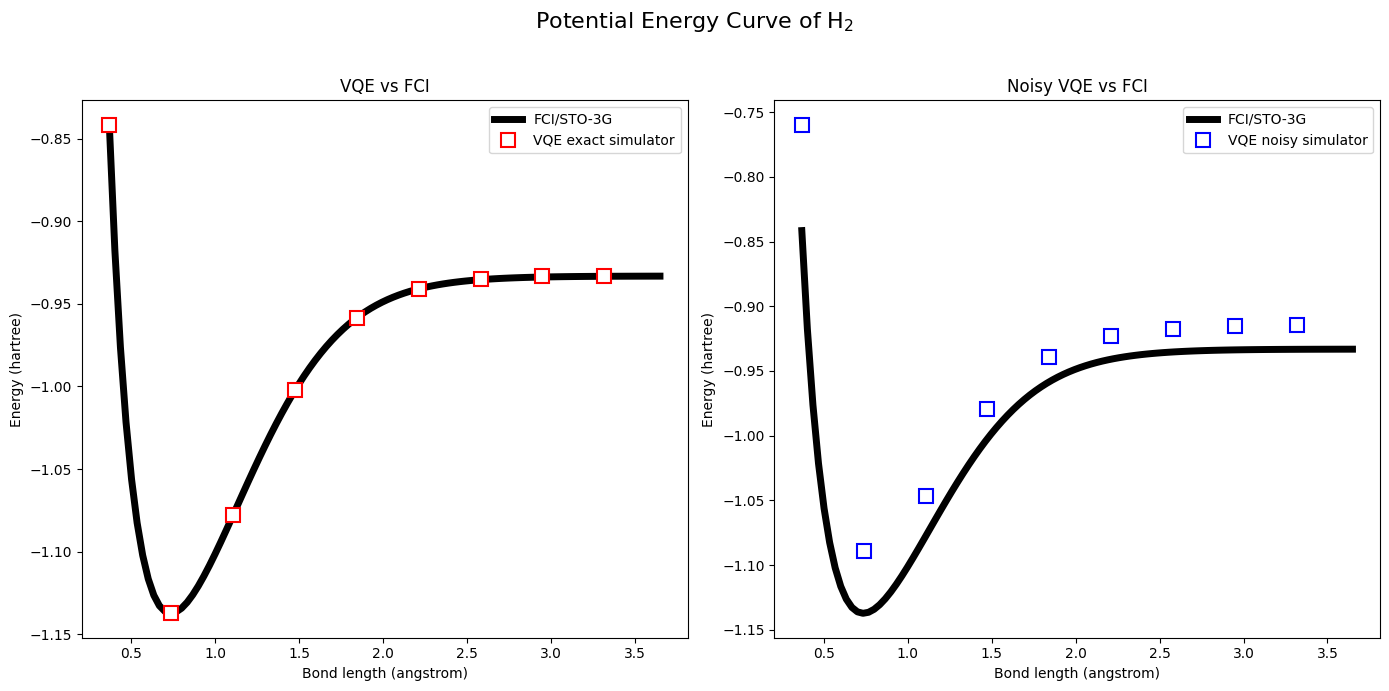

In [14]:
import numpy as np
from scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt

# read the data from the file
data_pyscf = np.loadtxt(f"{classical_output_file}")
data_quantum = np.loadtxt(f"{quantum_output_file}")
data_noisy_quantum = np.loadtxt(f"{noisy_quantum_output_file}")

# extract the columns
r = data_pyscf[:, 0]
energy = data_pyscf[:, 2]

r_quantum = data_quantum[:, 0]
energy_quantum = data_quantum[:, 1]
energy_noisy_quantum = data_noisy_quantum[:, 1]

# standard deviation 
std_quantum = 0.0 #np.sqrt((data_quantum[:, 2]))

# perform spline interpolation on the FCI/sto-3g energies using SciPy
spline = splrep(r, energy, s=0)

# evaluate the spline at more points for a smoother curve
r_interp = np.linspace(r.min(), r.max(), 100)
energy_interp = splev(r_interp, spline)

# create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# plot the interpolated data on the first subplot
ax1.plot(r_interp, energy_interp, label='FCI/STO-3G', linewidth=5, color='black')
ax1.plot(r_quantum, energy_quantum, label='VQE exact simulator', marker='s', markersize=10, color='red', linestyle='None', mfc='white', mew=2*0.75)
ax1.set_xlabel('Bond length (angstrom)')
ax1.set_ylabel('Energy (hartree)')
ax1.set_title('VQE vs FCI')
ax1.legend()
ax1.grid(False)

# plot the noisy quantum data on the second subplot
ax2.plot(r_interp, energy_interp, label='FCI/STO-3G', linewidth=5, color='black')
ax2.plot(r_quantum, energy_noisy_quantum, label='VQE noisy simulator', marker='s', markersize=10, color='blue', linestyle='None', mfc='white', mew=2*0.75)
ax2.set_xlabel('Bond length (angstrom)')
ax2.set_ylabel('Energy (hartree)')
ax2.set_title('Noisy VQE vs FCI')
ax2.legend()
ax2.grid(False)

# add a shared title
fig.suptitle('Potential Energy Curve of H$_2$', fontsize=16)

# adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Example #3: VQE vs. orbital-optimized VQE (oo-VQE)

In this example, we delve deeper into qchem quantum algorithms and demonstrate the use a variant of VQE, the orbital-optimized VQE (oo-VQE), for calculating ground-state energy of molecules. We utilize now `qc2`'s built-in algorithm package, *i.e.*, *VQE* and *OO_VQE* classes, along with `Qiskit Estimator` primitive to calculate the exact expectation values using `StateVector`. The water molecule is used as target system for this demonstration.


### Learning objectives

- Demonstrate the use of the `qc2` built-in algorithms package to easily run quantum algorithms.

- Provide a basic understanding of the orbital-optimized VQE and its application for finding ground-state energy of molecules.

### The VQE class in `qc2`

Let's first revisit the VQE and demonstrate how we can run all the above steps by simply instantiating the *VQE* class as implemented in `qc2`'s algorithms package. Here, we will use another very popular Python quantum computing SDK, `PennyLane`, which is also compatible with `qc2`.

In [15]:
# Import ASE-related modules
from ase.build import molecule

# Import qc2 modules
from qc2.data import qc2Data
from qc2.ase import PySCF
from qc2.algorithms.pennylane import VQE
from qc2.algorithms.utils import ActiveSpace

# Instantiate qc2Data class
qc2data = qc2Data(
    molecule=molecule("H2O"),
    filename="h2o.hdf5"
)

# Specify and run the quantum chemistry calculator
qc2data.molecule.calc = PySCF(method="scf.RHF", basis="sto-3g")
qc2data.run()

# Instantiate VQE class
qc2data.algorithm = VQE(
    active_space=ActiveSpace(
        num_active_electrons=(2, 2),
        num_active_spatial_orbitals=3
    ),
)

# Run VQE algorithm
vqe_results = qc2data.algorithm.run()

* Reference energy (Hartree): -74.96440482399433
* Saving qchem data in h2o.hdf5

>>> Optimizing circuit parameters...
iter = 000, energy = -74.964404823994 Ha
iter = 002, energy = -74.968213920275 Ha
iter = 004, energy = -74.968898463663 Ha
iter = 006, energy = -74.969030381047 Ha
iter = 008, energy = -74.969059948629 Ha
iter = 010, energy = -74.969068452995 Ha
iter = 012, energy = -74.969071671120 Ha
iter = 014, energy = -74.969073147697 Ha
iter = 016, energy = -74.969073893979 Ha
iter = 018, energy = -74.969074286914 Ha
iter = 020, energy = -74.969074497234 Ha
optimization finished.

=== PENNYLANE VQE RESULTS ===
* Electronic ground state energy (Hartree): -6.141912632777
* Inactive core energy (Hartree): -68.827161864457
>>> Total ground state energy (Hartree): -74.969074497234



### The oo-VQE algorithm and OO_VQE class

The figure below shows a general schematic representation of the oo-VQE workflow:

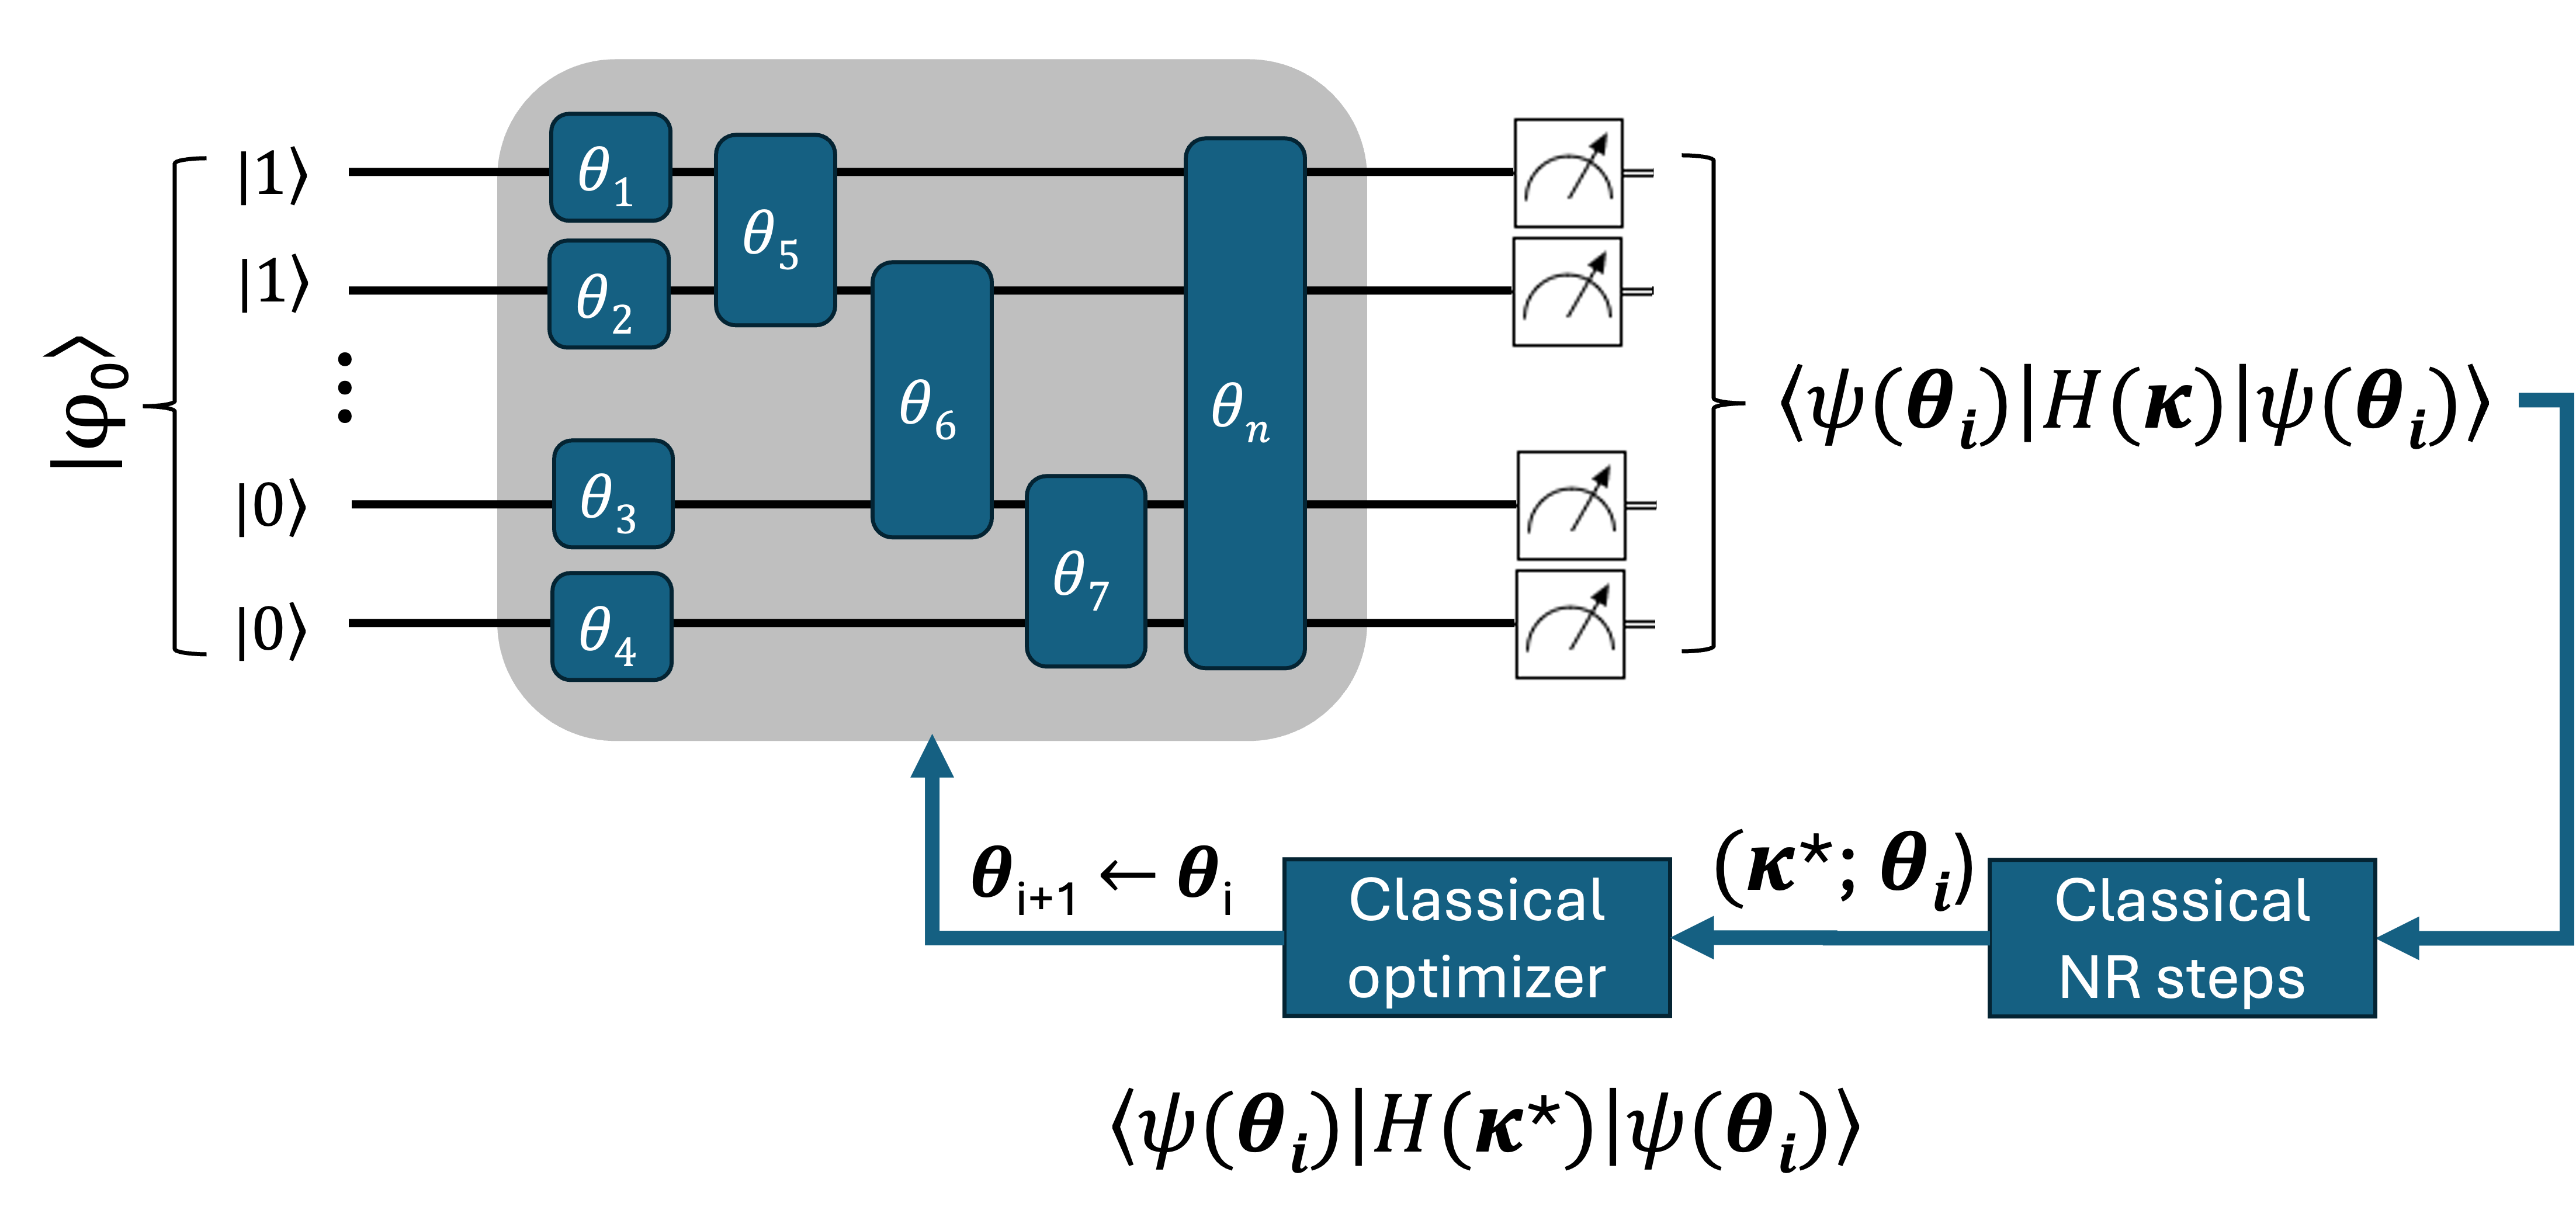

As seen, in oo-VQE, not only are the circuit parameters $\boldsymbol{\theta}$ optimized, but the original HF molecular orbitals are also rotated (relaxed) during the calculation. This is represented by an additional set of orbital rotation parameters $\boldsymbol{\kappa}$ that modify the original MO coefficients ($C \rightarrow C_{\rm HF} e^{-\boldsymbol{\kappa}}$) and are optimized via additional classical Newton-Raphson steps.

The general idea of oo-VQE is to minimize the energy functional:

\begin{equation}
E = \langle \Psi(\boldsymbol{\theta})| e^{-\boldsymbol{\kappa}} \hat{H} e^{\boldsymbol{\kappa}}| \Psi(\boldsymbol{\theta}) \rangle \equiv \langle \Psi(\boldsymbol{\theta})| \hat{H}(\boldsymbol{\kappa}) | \Psi(\boldsymbol{\theta}) \rangle,
\end{equation}
where $| \Psi(\boldsymbol{\theta}) \rangle $ represents the state of a parametrized quantum circuit, with the modified Hamiltonian given by:

\begin{equation}
\hat{H}(\boldsymbol{\kappa}) = \sum_{pq} \tilde{h}_{pq} a_{p}^\dagger a_{q} + \frac{1}{2} \sum_{pqrs} \tilde{h}_{pqrs} a_{p}^\dagger a_{q}^\dagger a_{r} a_{s}
\end{equation}

In the above expression, $\tilde{h}_{pq}$ and $\tilde{h}_{pqrs}$ are now one- and two-body integrals
\begin{equation}
\tilde{h}_{pq} = \sum_{ab} C^{*}_{ap}C_{bq} \langle a | \hat{h} | b \rangle \qquad \tilde{h}_{pqrs} = \sum_{abcd} C^{*}_{ap}C^{*}_{bq}C_{cr}C_{ds} \langle a b | \hat{g} | c d \rangle
\end{equation}
that are obtained using the new MO rotated coefficients $C = C_{\rm HF} e^{-\boldsymbol{\kappa}}$.

Note that $\langle a | \hat{h} | b \rangle$ and $ \langle a b | \hat{g} | c d \rangle $ are the usual one- and two-electron integrals that can be easily extracted from a traditional HF calculation.

In `qc2`, all the above steps are encapsulated within the *OO_VQE* class. The example below shows how a oo-VQE algorithm can be run in `qc2` by simply instantiating this class:

In [16]:
# Import ASE-related modules
from ase.build import molecule

# Import qc2 modules
from qc2.data import qc2Data
from qc2.algorithms.qiskit import OO_VQE
from qc2.algorithms.utils import ActiveSpace

# Instantiate qc2Data class
qc2data = qc2Data(
    molecule=molecule("H2O"),
    filename="h2o.hdf5"
)

# if you want to keep using the ab intio data from a previous calculation as contained in "h2o.hdf5"
# you do not need to define a qc2-ASE calculator

# Instantiate OO_VQE class
qc2data.algorithm = OO_VQE(
    active_space=ActiveSpace(
        num_active_electrons=(2, 2),
        num_active_spatial_orbitals=3
    ),
)

# Run oo-VQE algorithm
oo_vqe_results = qc2data.algorithm.run()

>>> Optimizing circuit and orbital parameters...
iter = 000, energy = -74.964404823994 Ha
iter = 001, energy = -74.972601792398 Ha
iter = 002, energy = -74.975548164872 Ha
iter = 003, energy = -74.976285806693 Ha
iter = 004, energy = -74.976516726930 Ha
iter = 005, energy = -74.976597452131 Ha
iter = 006, energy = -74.976626589628 Ha
iter = 007, energy = -74.976637210362 Ha
iter = 008, energy = -74.976641104324 Ha
iter = 009, energy = -74.976642302617 Ha
iter = 010, energy = -74.976643039744 Ha
iter = 011, energy = -74.976643213709 Ha
iter = 012, energy = -74.976643270035 Ha
optimization finished.

=== QISKIT oo-VQE RESULTS ===
* Total ground state energy (Hartree): -74.976643270035


Note that the structure of the input is exactly the same as before, with the exception that we are now instantiating and running a different algorithm class. A distinct qc2-ASE calculator could also be used such as DIRAC or your own calculator, with minimal changes and effort. This is a hallmark of qc2. Additionally, since we have previously completed a HF calculation in our VQE example above and saved all relevant *ab initio* data in `h2o.hdf5`, we simply skipped this step and proceeded directly to defining the *OO_VQE* class. In this scenario, qc2 automatically reads the data contained in `h2o.hdf5`.

### Comparison with traditional qchem calculations

Now, let's compare our VQE and oo-VQE energies with quantum chemistry calculations performed solely using PySCF. Here is a typical example run:

In [17]:
from pyscf import gto, scf, mcscf, fci

# set up molecule
mol_h2o = gto.M(
    atom='O 0 0 0.1192622641;\
          H 0 0.763237638 -0.4770469398;\
          H 0 -0.763237638, -0.4770469398',
    basis='sto-3g',
    verbose=0
)

# run HF
scf_h2o = scf.HF(mol_h2o)
hf_h2o = mol_h2o.HF().run()

# run CASCI and CASSCF single-point calculations
ncas, nelecas = (3, 4)
energy_casci = mcscf.CASCI(hf_h2o, ncas, nelecas).kernel()
energy_casscf = mcscf.CASSCF(hf_h2o, ncas, nelecas).kernel()

# run FCI single-point calculation
energy_fci = fci.FCI(hf_h2o).kernel()

print('')
print(f'* Final VQE energy (hartree):           {vqe_results.optimal_energy:.6f}')
print(f'* Final oo-VQE energy (hartree):        {oo_vqe_results.optimal_energy:.6f}')
print(f'* Final CASCI/sto-3g energy (hartree):  {energy_casci[0]:.6f}')
print(f'* Final CASSCF/sto-3g energy (hartree): {energy_casscf[0]:.6f}')
print(f'* Final FCI/sto-3g energy (hartree):    {energy_fci[0]:.6f}')


* Final VQE energy (hartree):           -74.969074
* Final oo-VQE energy (hartree):        -74.976643
* Final CASCI/sto-3g energy (hartree):  -74.969075
* Final CASSCF/sto-3g energy (hartree): -74.976643
* Final FCI/sto-3g energy (hartree):    -75.015429


### Plot of VQE and oo-VQE energy convergence

To facilitate our discussion, we plot below the energy convergence of ground-state water as obtained using the above `qc2` input examples. Also shown for comparison are the corresponding results obtained above with PySCF.

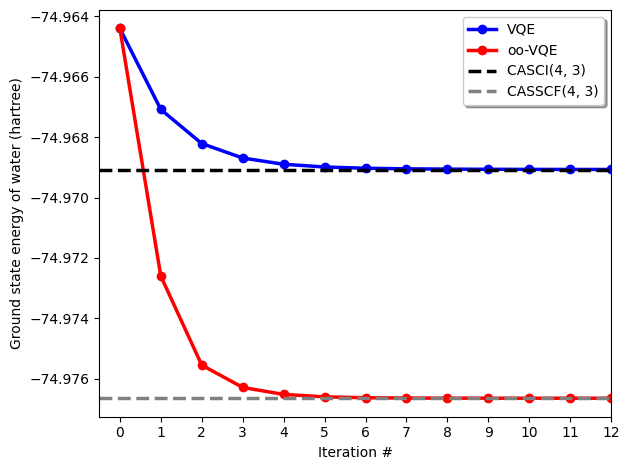

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# define ab initio energies calculated classicaly
e_casci = energy_casci[0]
e_casscf = energy_casscf[0]
e_fci = energy_fci[0]

# vqe energy
x_vqe = np.arange(len(vqe_results.energy))
y_vqe = vqe_results.energy

# oo-vqe energy
x_oovqe = np.arange(len(oo_vqe_results.energy))
y_oovqe = oo_vqe_results.energy

# plot energy convergence from quantum algorithms
plt.figure()
plt.plot(x_vqe, y_vqe, label='VQE', marker='o', linewidth=2.5, markersize=6, color='blue')# markerfacecolor='none')
plt.plot(x_oovqe, y_oovqe, label='oo-VQE', marker='o', linewidth=2.5, markersize=6, color='red')

# plot reference values at CASCI and CASSCF levels
plt.axhline(y=e_casci, label=f'CASCI({nelecas}, {ncas})', color='black', linestyle='--', linewidth=2.5)
plt.axhline(y=e_casscf, label=f'CASSCF({nelecas}, {ncas})', color='gray', linestyle='--', linewidth=2.5)
# plt.axhline(y=e_fci, label='FCI/STO-3G', color='orange', linestyle='--', linewidth=2.5)

plt.xlabel('Iteration #')
plt.ylabel('Ground state energy of water (hartree)')
plt.legend(facecolor='white', framealpha=1, shadow=True)
plt.xticks(np.arange(min(x_oovqe), max(x_oovqe)+1, 1))
plt.xlim(-0.5, 12)
plt.title("")

plt.tight_layout()
plt.show()

As expected, oo-VQE energies are variationally lower and converge nearly exactly to the predicted CASSCF values. Since all initial circuit (and orbital rotation) parameters are set to zero by default, both VQE and oo-VQE initiate their interactive processes at the HF energy.